<div class="alert alert-info alert-info"><b><h1>Quin és l'objectiu?</h1></b>

Tal com hem vist, els <b>grafs</b> són una estructura matemàtica per representar relacions entre elements. Aquests elements estan formats per nodes i vèrtex. En el nostre cas, utilitzarem Twitter per crear el que es diu "Social network analysis"

</div>

<div class="alert alert-success alert-success"><b><h1>1. Posar les dades en un dataframe</h1></b>

Anem a crear un graph senzill. Anem a utilitzar com a nodes els usuaris i la relació serà 1-1. Aquesta gràfica no és de les més interessants, però està bé per començar a visualitzar el que hem creat.

<ul><li>1. El primer pas serà posar les dades trobades en un dataframe. "Source" serèm nosaltres, el node principal, i "Target" seran els següidors</li>
    <li>2. Utilitzarem la llibreria networkx per representar el gràfic </li></ul></div>

In [1]:
import pandas as pd
import networkx as nx

In [2]:
columns=['source','target']
df = pd.read_csv('source.csv', header = None, names=columns)

In [3]:
df

,source,target
0,8826,1910
1,7659,1
2,2,607
3,342,3
4,4,3
...,...,...
56671,9441,8885
56672,9442,6870
56673,9443,2879
56674,9444,722


<div class="alert alert-warning alert-warning">
<b>Gràfica</b>

Per crear aquesta gràfica, utilitzarem la llibreria <b>network</b>. Com no indiquem els pesos, la distancia entre nodes serà la mateixa!
    
Si t'interessa veure altres layauts, pots consultar el següent [link](https://networkx.org/documentation/stable/reference/drawing.html)
</div>

In [19]:
#!pip list

In [5]:
G = nx.from_pandas_edgelist(df, 'source', 'target') #Turn df into graph
pos = nx.spring_layout(G) #specify layout for visual, pos és la posisió dels nodes

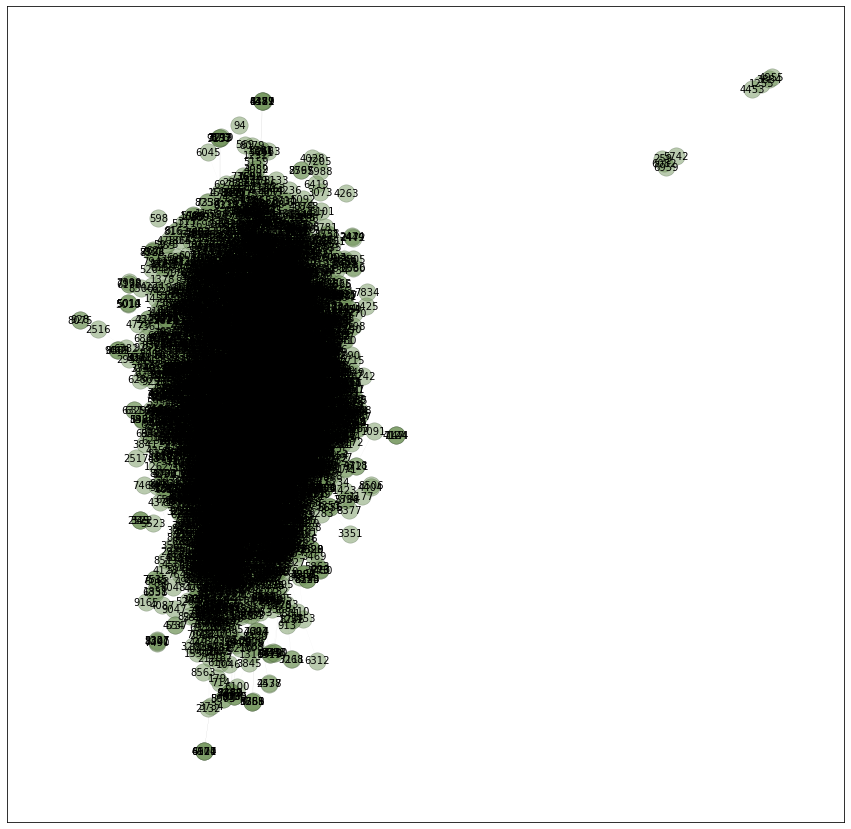

In [6]:
import matplotlib.pyplot as plt ## import llibreria


f, ax = plt.subplots(figsize=(15, 15)) ## Tamany plot
ax.set_facecolor('white') ## Fons blanc

plt.style.use('ggplot') ## Diem que serà un graph


nodes = nx.draw_networkx_nodes(G, pos, alpha=0.5, node_color='#75975e') ## nodes
nodes.set_edgecolor('#4b6043')
nx.draw_networkx_labels(G, pos, font_size=10) ## Descomenta per visualitzar l'ID dels usuaris
nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.1) ## edges

# Guardar imagen
plt.savefig("graph.png")

<div class="alert alert-success alert-success"><b><h1>4. Seguidors dels seguidors</h1></b>

El que ens interessa arribar a tenir és els seguidors del nostre node principal. Per fer-ho, farem un loop que mira els followers i els guardarem al nostre dataframe. Aquest codi el podem córrer tants cops com vulguem. Això crearia una xarxa molt més gran, però ves amb compte, ja que el nostre objectiu és trobar un graf propi, si comences a buscar seguidors de seguidors, és possible que aquests grafs siguin molt pesats. Et recomano només córrer aquest codi un cop!

<b> És important tenir en compte que Twitter API limita en nombre de trucades. Per tant, si la teva xarxa és molt gran, és possible que estiguis una bona estona, ja que t'has d'esperar 15 min entre trucada i trucada! A més, només agafarem els 5000 primers followers, per agilitzar la feina!</b></div>

<div class="alert alert-warning alert-warning">
<b>Atenció!</b>
Fixa't que si t'avorreixes, pots parar el procés en qualsevol moment, les dades es van guardant en un CVS! Però la teva xarxa quedarà incompleta!
</div>

<div class="alert alert-success alert-success"><b><h1>5. Social graph!</h1></b>
    
Ara és moment de representar la nostra gràfica social. Primerament llegirem la nostra base de dades <b>networkOfFollowers.csv</b>. Aqui tenim nous nodes, dels contactes propers i dels seguidors d'aquests. Anem a representar les interaccions socials!
</div>

In [7]:
df.source = df.source.astype('int64')
df.target = df.target.astype('int64')
G = nx.from_pandas_edgelist(df, 'source', 'target') ## Create graph

In [8]:
G.number_of_nodes() #Find the total number of nodes in this graph

8742

<div class="alert alert-info alert-info"><b><h1>Com masurarem la distància entre els nodes?</h1></b>

Com hem vist anteriorment, els grafs es representen entre els nodes i les arestes. Els nodes són representats pels usuaris i l'aresta dependrà de la interpretació que vulguem fer de la xarxa. Anteriorment, l'aresta representava una relació 1-1, on era la representació seguidor, i la distància és la mateixa. Cada node tenia el mateix pes, ja que no hi havia usuaris de més importància que d'altres.
    
En aquest cas el que volem és trobar quins nodes són els més influents, per tant, aquests que tenen molts seguidors i a la vegada molta gent els segueix. Per fer-ho, utilitzarem Degree Centrality, que és una mesura de centralitat, on ens dona una funció del nombre de connexions que el node té.
    

</div>

In [9]:
df_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
df_sorted.columns = ['node','degree']
df_sorted.head()

,node,degree
0,6016,48
1,3836,43
2,4218,41
3,7623,36
4,2918,36


In [10]:
G = nx.k_core(G, 2) #Exclude nodes with degree less than 10

<div class="alert alert-info alert-info"><b><h1>Com representem les diferents comunitats socials?</h1></b>
    
Hem comentat que els nodes que tinguin més interacció entre ells es representaran més propers, però a més és possible dividir aquestes comunitats. Per fer-ho, utilitzarem <a href="https://python-louvain.readthedocs.io/en/latest/api.html"><b>community_louvain</b></a>, que ens permet fer aquesta divisió dels nodes en diferents grups. Aquesta divisió es fa mitjançant <b> community detection algorithm</b>

</div>


 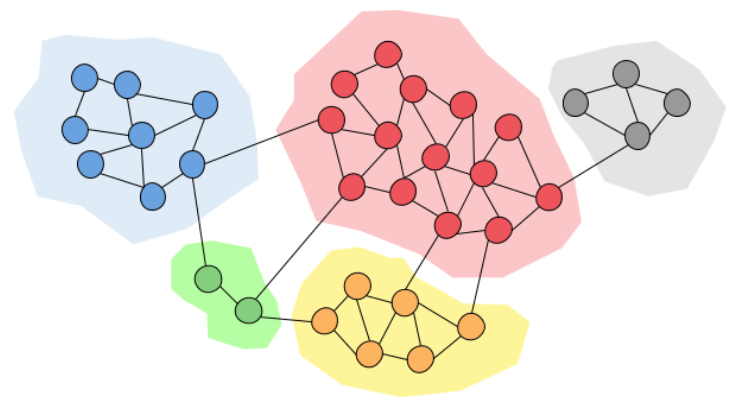

In [11]:
from community import community_louvain

partition_louvain = community_louvain.best_partition(G)
#Turn partition into dataframe
partition = pd.DataFrame([partition_louvain]).T
partition = partition.reset_index()
partition.columns = ['names','group']

In [12]:
partition.head()

,names,group
0,8826,0
1,1910,0
2,7659,1
3,1,1
4,2,2


<div class="alert alert-info alert-info">
    
Necessitem tornar a buscar quin és el degree, ja que la nostra xarxa ha passat a ser menys nodes
</div>


In [13]:
df_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
df_sorted.columns = ['names','degree']
df_sorted.head()

,names,degree
0,6016,48
1,3836,43
2,4218,41
3,7623,36
4,2918,36


<div class="alert alert-info alert-info">
Ara creem la base de dades completa, amb el node, el degree i la partició creada
</div>


In [14]:
combined = pd.merge(df_sorted, partition, how='left', left_on="names",right_on="names")

In [15]:
combined.head()

,names,degree,group
0,6016,48,16
1,3836,43,16
2,4218,41,21
3,7623,36,19
4,2918,36,21


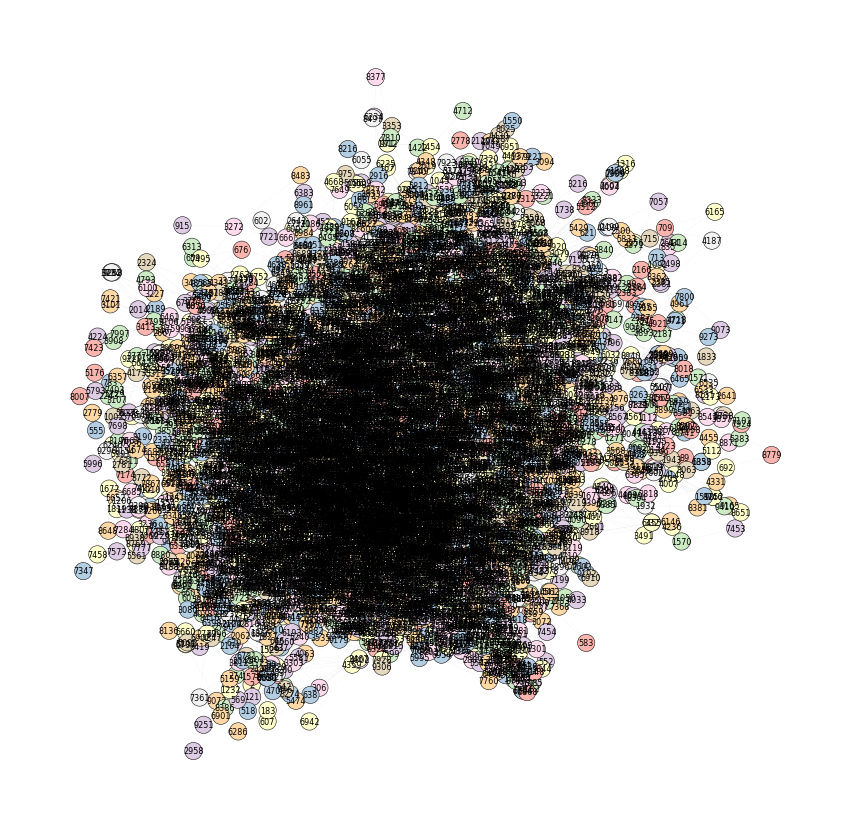

In [16]:
import matplotlib.pyplot as plt ## import llibreria

pos = nx.spring_layout(G)
f, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('white')
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               cmap=plt.cm.Pastel1,
                               node_color=combined['group'],
                               alpha=1)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.2)
plt.savefig('similarMovies.png')

<div class="alert alert-success alert-success"><b><h1>6. Conclusions</h1></b>
    
Com pots observar, aquí veiem els nodes superposats, ja que les connexions entre ells són molt difícils de representar utilitzant matplotlib. Segurament, amb una base de dades més petita, d'un usuari amb menys connexions, pots visualitzar més fàcilment les diferents connexions. Per exemple, aquí hi ha representada una gràfica d'una xarxa social personal:
</div>

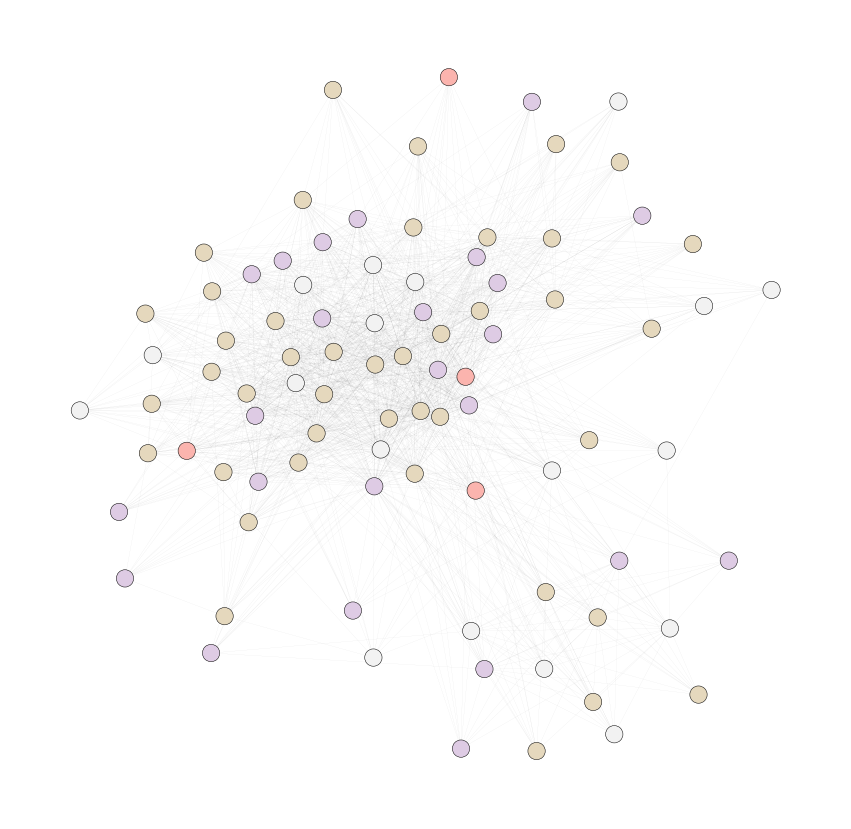

<div class="alert alert-success alert-success">
    
Aqui veiem molt millor representats els grups socials, ja que les diferents agrupacions tenen més distància entre elles.
    
Per poder visualitzar millor, necessitarem millors eines.

</div>

<div class="alert alert-success alert-success"><b><h1>7. Gephi</h1></b>
    
</div>

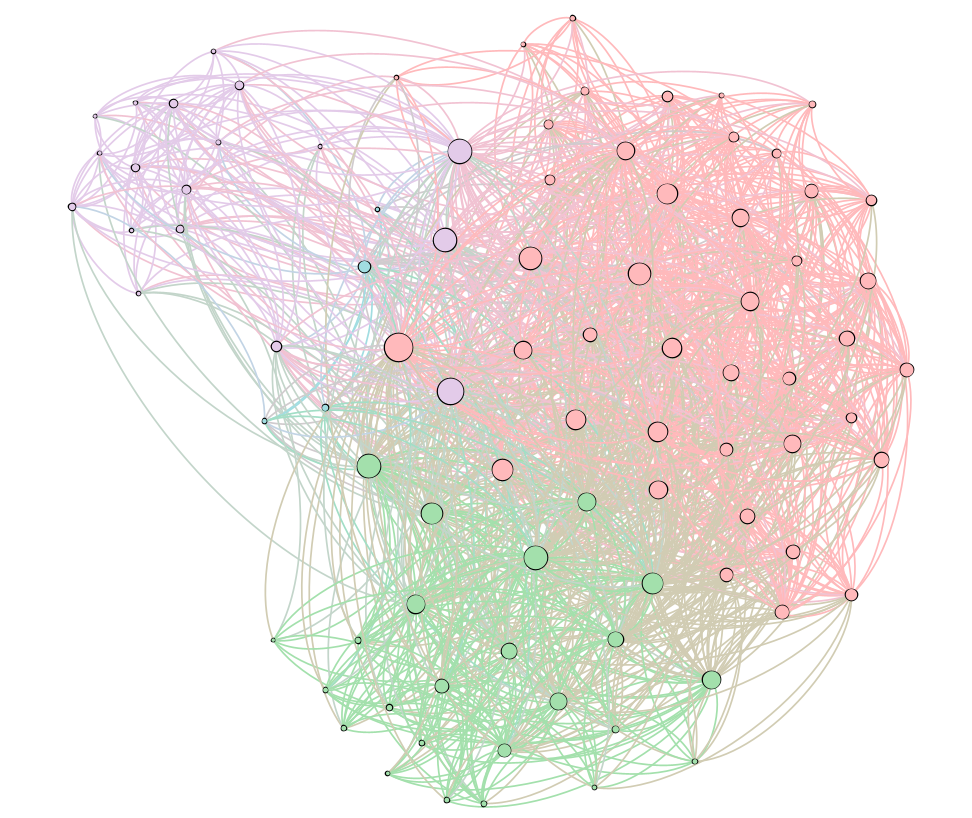

In [17]:
combined = combined.rename(columns={"names": "Id"}) #I've found Gephi really likes when your node column is called 'Id'
edges = nx.to_pandas_edgelist(G)
edges = edges.rename(columns={"source": "Source",'target':'Target'})

edges.to_csv("edges.csv", index=False)
combined.to_csv("nodes.csv", index=False)

In [18]:
combined

,Id,degree,group
0,6016,48,16
1,3836,43,16
2,4218,41,21
3,7623,36,19
4,2918,36,21
...,...,...,...
8030,2404,2,8
8031,9245,2,4
8032,4668,2,23
8033,7128,2,29


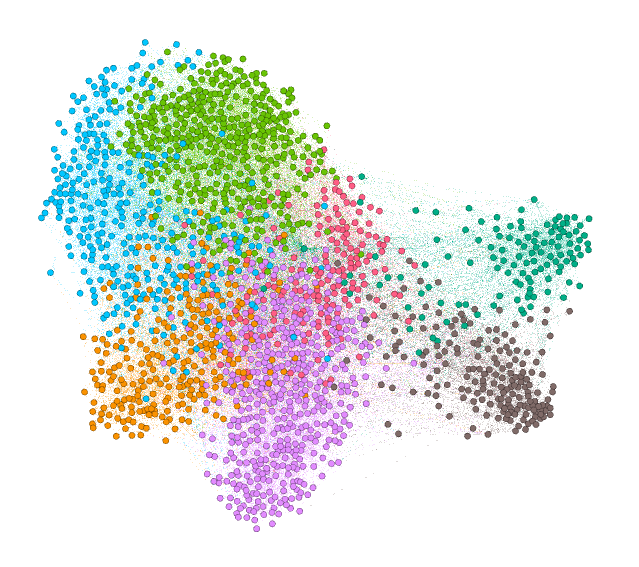

<div class="alert alert-info alert-info">
Aqui podem veure, utilitzant el mètode "ForceAtlas2" de Gephi, els diferents grups! A més, podem visualitzar els nodes més importants!

Telecogresca està representat com el node més gran!
</div>

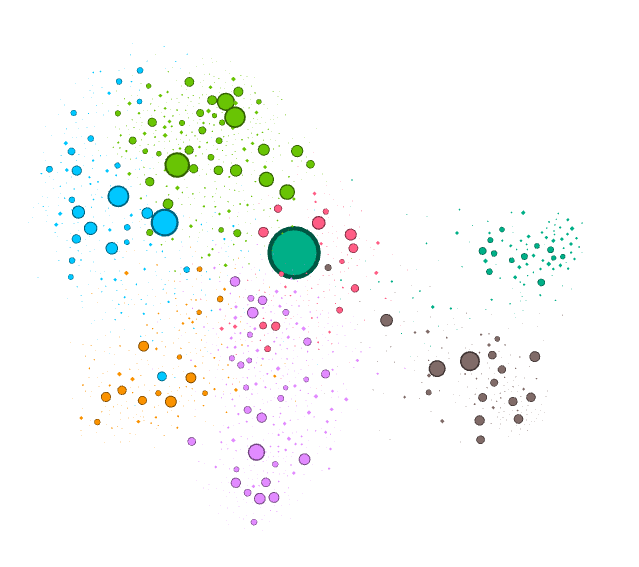